# Semi-structured eval: Long-context

`Semi-structured Reports` is a public dataset that contains question-answer pairs from documents with text and tables.

The question-answer pairs are derived from the tables as well as some of the paragraphs in the docs.

We evaluation performance of long context LLMs on this dataset.

In [ ]:
# %pip install -U langchain langsmith langchain_benchmarks
# %pip install -U anthropic openai

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
env_vars = ["LANGCHAIN_API_KEY", "OPENAI_API_KEY", "ANTHROPIC_API_KEY"]
for var in env_vars:
    if var not in os.environ:
        os.environ[var] = getpass.getpass(prompt=f"Enter your {var}: ")

## Dataset

Fetch the associated PDFs from remote cache for the dataset so that we can perform ingestion.

In [1]:
import os

from langchain_benchmarks import clone_public_dataset, registry
from langchain_benchmarks.rag.tasks.semi_structured_reports import get_file_names

# Task
task = registry["Semi-structured Reports"]

# Files used
paths = list(get_file_names())
files = [str(p) for p in paths]

Clone the dataset so that it's available in our LangSmith datasets.

In [2]:
clone_public_dataset(task.dataset_id, dataset_name=task.name)

  0%|          | 0/30 [00:00<?, ?it/s]

Finished fetching examples. Creating dataset...
New dataset created you can access it at https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/6549a3a5-1cb9-463f-951d-0166cb9cf45c.
Done creating dataset.


## Load

Concatenate the documents.

In [7]:
from langchain.document_loaders import PyPDFLoader

texts = []
for fi in files:
    loader = PyPDFLoader(fi)
    pdf_pages = loader.load()
    texts.extend(pdf_pages)

texts = [t.page_content for t in texts]
text_string = " /// New Document /// ".join(texts)

## Run

Create a chain for each long-context LLM where we pass in the concatenated documents.

In [8]:
from langchain.chat_models import ChatAnthropic, ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough


def create_chain(model):
    # Prompt template
    template = """Answer the question based only on the following context, which can include text and tables:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    chain = (
        {
            "context": lambda x: text_string,
            "question": RunnablePassthrough(),
        }
        | prompt
        | model
        | StrOutputParser()
    )

    return chain


# OAI 128k
model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")
chain_oai_128k = create_chain(model)

# Anthropic 100k, v2
model = ChatAnthropic(temperature=0, model="claude-2")
chain_claude = create_chain(model)

# Anthropic 100k, v2.1
model = ChatAnthropic(temperature=0, model="claude-2.1")
chain_2_1_claude = create_chain(model)

## Eval

Run eval onm our dataset, `Semi-structured Reports`.

In [ ]:
import uuid

from langchain.smith import RunEvalConfig
from langsmith.client import Client

# Config
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    "oai_128k": chain_oai_128k,
    "claude2_100k_v2": chain_claude,
    "claude2_100k_v2.1": chain_2_1_claude,
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    test_runs[project_name] = client.run_on_dataset(
        dataset_name=task.name,
        llm_or_chain_factory=lambda: (lambda x: x["Question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{run_id}-{project_name}",
        project_metadata={"chain": project_name},
    )

## Failure Analysis

Look at failures for `GPT-4 128k` wrt the answer location in the context.

[Prior](https://twitter.com/GregKamradt/status/1722386725635580292) [work](https://twitter.com/GregKamradt/status/1727018183608193393) has done this for long context LLMs.

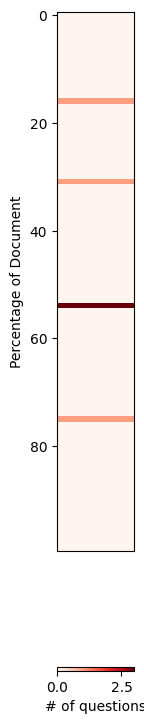

In [59]:
import matplotlib.pyplot as plt
import numpy as np


def find_all_phrase_locations(phrases, text):
    """
    # Function to find all locations of each phrase in the text string
    """
    locations = []
    for phrase in phrases:
        start = 0
        while start < len(text):
            start = text.find(phrase, start)
            if start == -1:  # No more occurrences
                break
            # Convert location to percentage of the document
            location_percent = (start / len(text)) * 100
            locations.append(location_percent)
            start += len(phrase)  # Move past this occurrence
    return locations


# Unique statments related to each failed question
short_phrase_list = [
    "Booking.com, GoDaddy",  # AWS question
    "MICROSOFT CORPORATIONINCOME STATEMENTS",  # MSFT
    "Operating income $ 5,403",  # AWS question
    "Net sales $ 20,538 $ 23,059",  # AWS question
    "Research and development (1)(3) 240,225  205,388",  # DDOG
    "Net sales $ 78,843 $ 87,887",  # AWS question
]

# Finding all the locations of each phrase in the text_string
phrase_locations = find_all_phrase_locations(short_phrase_list, text_string)

# Create a 2D matrix for heatmap
heatmap_matrix = np.zeros((1, 100))
for location in phrase_locations:
    segment = int(location)
    heatmap_matrix[0, segment] += 1  # Increment the count for the segment

# Invert the matrix so that x and y are flipped
inverted_heatmap_matrix = np.transpose(heatmap_matrix)

# Plotting the inverted heatmap
fig, ax = plt.subplots(figsize=(1, 10))  # Adjust figure size to make x-axis narrower
cax = ax.imshow(
    inverted_heatmap_matrix,
    cmap="Reds",
    aspect="auto",
    vmin=0,
    vmax=inverted_heatmap_matrix.max(),
)
fig.colorbar(cax, label="# of questions", orientation="horizontal")
ax.set_ylabel("Percentage of Document")
ax.set_xticks([])
plt.show()